In [1]:
# Import the required packages and functions
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from ml_control.problem_definitions.heat_equation import create_heat_equation_problem_complex
from ml_control.reduced_model import ReducedModel
from ml_control.machine_learning_models.kernel_reduced_model import KernelReducedModel
from ml_control.systems import solve_optimal_control_problem, get_control_from_final_time_adjoint, solve_system
from ml_control.visualization import plot_final_time_adjoints, plot_controls, plot_final_time_solutions

In [2]:
# Define the system components
system_dimension = 50
T, nt, N, h, parametrized_A, parametrized_B, parametrized_x0, parametrized_xT, R_chol, M, parameter_space = create_heat_equation_problem_complex(system_dimension)
spatial_norm = lambda x: np.linalg.norm(h * x)
temporal_norm = lambda u: np.linalg.norm(u * (T / nt))

In [3]:
# Read precomputed greedy results from file
with open("greedy_results.pkl", "rb") as f:
    reduced_basis, estimated_errors, true_errors, efficiencies, training_data, singular_values, tol = pickle.load(f)

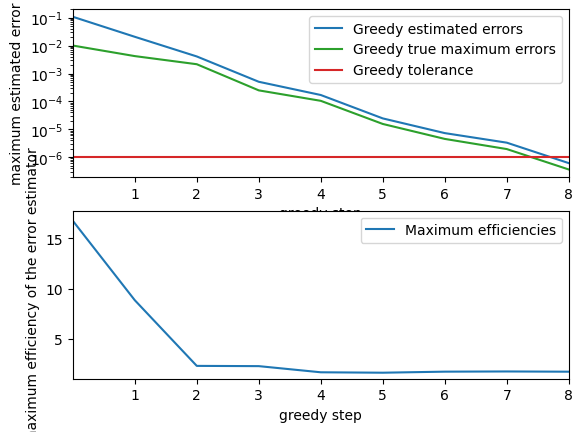

In [4]:
# Plot the greedy errors
fig, axs = plt.subplots(2)
axs[0].semilogy(np.arange(0, len(estimated_errors)), estimated_errors, 'tab:blue', label='Greedy estimated errors')
axs[0].semilogy(np.arange(0, len(estimated_errors)), true_errors, 'tab:green', label='Greedy true maximum errors')
axs[0].plot(np.arange(0, len(estimated_errors)), [tol] * len(estimated_errors), 'tab:red', label='Greedy tolerance')
axs[0].set_xlim((0., len(reduced_basis)))
axs[0].set_xlabel('greedy step')
axs[0].set_ylabel('maximum estimated error')
axs[0].set_xticks(np.arange(0, len(reduced_basis)) + 1)
axs[0].legend()
axs[1].plot(np.arange(0, len(estimated_errors)), efficiencies, 'tab:blue', label='Maximum efficiencies')
axs[1].set_xlim((0., len(reduced_basis)))
axs[1].set_ylim((1., np.max(efficiencies) + 1))
axs[1].set_xlabel('greedy step')
axs[1].set_ylabel('maximum efficiency of the error estimator')
axs[1].set_xticks(np.arange(0, len(reduced_basis)) + 1)
axs[1].legend()
plt.show()

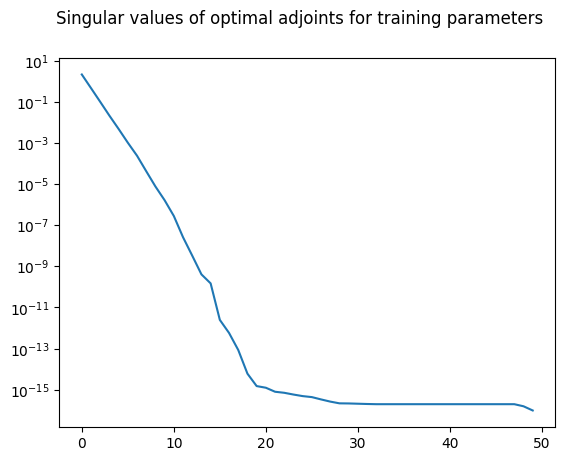

In [5]:
# Plot singular values of optimal final time adjoints
fig = plt.figure()
fig.suptitle("Singular values of optimal adjoints for training parameters")
ax = fig.add_subplot(111)
ax.semilogy(singular_values)
plt.show()

In [6]:
# Instantiate the reduced model
rb_rom = ReducedModel(reduced_basis, N, T, nt, parametrized_A, parametrized_B, parametrized_x0, parametrized_xT, R_chol,
                      M, spatial_norm=spatial_norm)

In [7]:
# Instantiate and train the machine learning model
ml_rom = KernelReducedModel(rb_rom, training_data, T, nt, parametrized_A, parametrized_B, parametrized_x0,
                            parametrized_xT, R_chol, M, spatial_norm=spatial_norm)
ml_rom.train()


****************************** [VKOGA] ******************************
Training model with
       |_ kernel              : gauss [gamma = 1.00e+00]
       |_ regularization par. : 0.00e+00
       |_ restriction par.    : 0.00e+00

Training ongoing with
       |_ selected points     :        1 /       56
       |_ train residual      : 2.03e-01 / 1.00e-10
       |_ train power fun     : 1.00e+00 / 1.00e-10
Training ongoing with
       |_ selected points     :       11 /       56
       |_ train residual      : 5.20e-04 / 1.00e-10
       |_ train power fun     : 3.73e-03 / 1.00e-10
Training ongoing with
       |_ selected points     :       21 /       56
       |_ train residual      : 4.60e-06 / 1.00e-10
       |_ train power fun     : 1.31e-05 / 1.00e-10
Training ongoing with
       |_ selected points     :       31 /       56
       |_ train residual      : 3.40e-08 / 1.00e-10
       |_ train power fun     : 9.71e-08 / 1.00e-10
Training ongoing with
       |_ selected points     :    

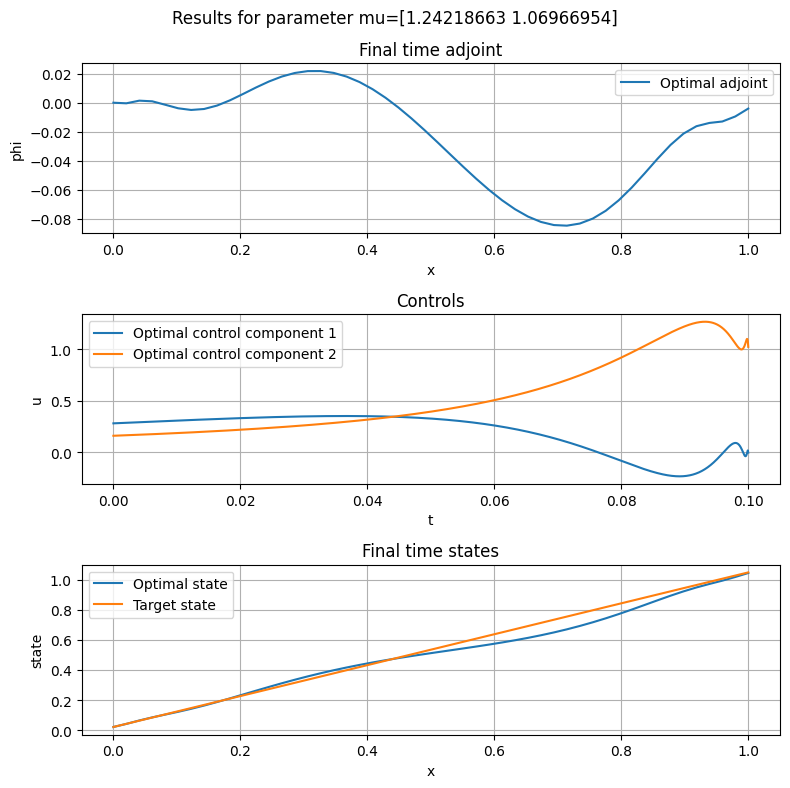

In [22]:
# Run the full model for a test parameter
mu = np.hstack([np.random.uniform(np.array(parameter_space)[0,0], np.array(parameter_space)[0,1]),
                np.random.uniform(np.array(parameter_space)[1,0], np.array(parameter_space)[1,1])])

# parameter space (for which the reduced models were trained): [1, 2] x [0.5, 1.5]
#mu = np.array([1.5, 1.0])

x0 = parametrized_x0(mu)
xT = parametrized_xT(mu)
A = parametrized_A(mu)
B = parametrized_B(mu)
phiT_init = np.zeros(N)
tic = time.perf_counter()
phi_opt = solve_optimal_control_problem(x0, xT, T, nt, A, B, R_chol, M, phiT_init)
u_opt = get_control_from_final_time_adjoint(phi_opt, T, nt, A, B, R_chol)
time_full = time.perf_counter() - tic
x_opt = solve_system(x0, T, nt, A, B, u_opt)

fig, axs = plt.subplots(3, figsize=(8, 8))
plot_final_time_adjoints([phi_opt], labels=["Optimal adjoint"], show_plot=False, ax=axs[0])
axs[0].set_title("Final time adjoint")
axs[0].legend()
plot_controls([u_opt], T, labels=["Optimal control"], show_plot=False, ax=axs[1])
axs[1].set_title("Controls")
axs[1].legend()
plot_final_time_solutions([x_opt[-1], xT], labels=["Optimal state", "Target state"], show_plot=False, ax=axs[2])
axs[2].set_title("Final time states")
axs[2].legend()
fig.suptitle(f"Results for parameter mu={mu}")
fig.tight_layout()
plt.show()

In [9]:
# Run the two reduced models for the test parameter
tic = time.perf_counter()
u_rb, phi_rb = rb_rom.solve(mu)
time_rb = time.perf_counter() - tic

tic = time.perf_counter()
u_ml, phi_ml = ml_rom.solve(mu)
time_ml = time.perf_counter() - tic

In [10]:
print("Full model:")
print("===========")
print(f"Runtime: {time_full}")

print()
print("Reduced model:")
print("==============")
print(f"Reduced basis size: {len(rb_rom.reduced_basis)}")
print(f"Runtime: {time_rb}")
print(f"Speedup: {time_full / time_rb}")
print(f"Relative error in final time adjoint: {spatial_norm(phi_opt - phi_rb) / spatial_norm(phi_opt)}")
print(f"Error in control: {temporal_norm(u_opt - u_rb)}")

print()
print("ML reduced model:")
print("=================")
print(f"Runtime: {time_ml}")
print(f"Speedup: {time_full / time_ml}")
print(f"Relative error in final time adjoint: {spatial_norm(phi_opt - phi_ml) / spatial_norm(phi_opt)}")
print(f"Error in control: {temporal_norm(u_opt - u_ml)}")

Full model:
Runtime: 4.7210636381059885

Reduced model:
Reduced basis size: 8
Runtime: 1.5911615011282265
Speedup: 2.967054968812706
Relative error in final time adjoint: 7.635485279330448e-06
Error in control: 4.721489081965696e-09

ML reduced model:
Runtime: 0.14296641573309898
Speedup: 33.02218646174668
Relative error in final time adjoint: 8.78176371980049e-06
Error in control: 9.397260113681544e-09


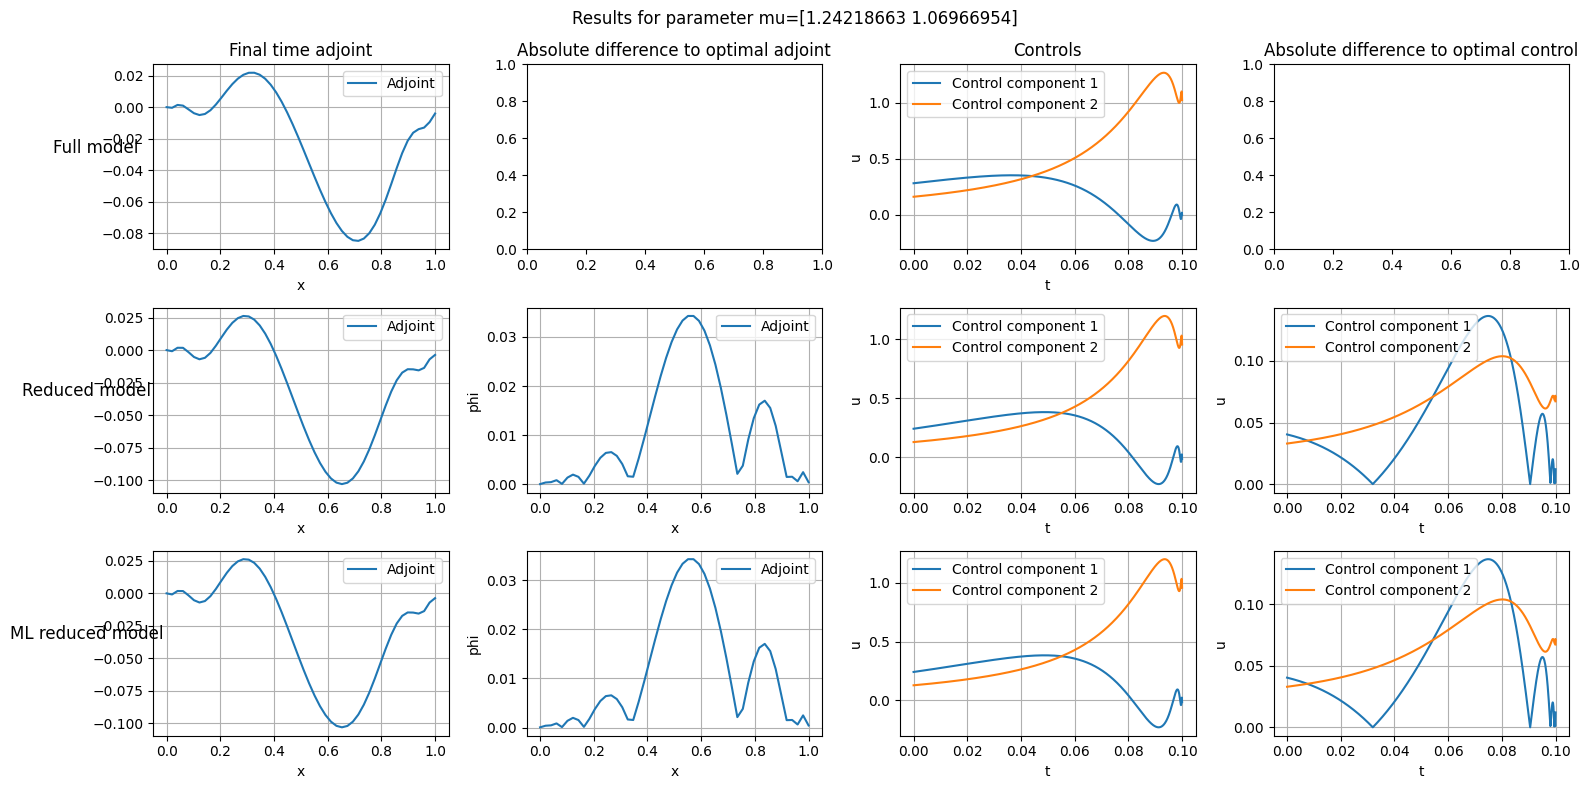

In [38]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
plot_final_time_adjoints([phi_opt], show_plot=False, ax=axs[0, 0])
axs[0, 0].set_title("Final time adjoint")
axs[0, 0].set_ylabel("Full model", rotation=0, size='large')
plot_controls([u_opt], T, show_plot=False, ax=axs[0, 2])
axs[0, 1].set_title("Absolute difference to optimal adjoint")
axs[0, 2].set_title("Controls")
plot_final_time_adjoints([phi_rb], show_plot=False, ax=axs[1, 0])
axs[0, 3].set_title("Absolute difference to optimal control")
axs[1, 0].set_ylabel("Reduced model", rotation=0, size='large')
plot_final_time_adjoints([np.abs(phi_opt - phi_rb)], show_plot=False, ax=axs[1, 1])
plot_controls([u_rb], T, show_plot=False, ax=axs[1, 2])
plot_final_time_adjoints([phi_ml], show_plot=False, ax=axs[2, 0])
plot_controls([np.abs(u_opt - u_rb)], T, show_plot=False, ax=axs[1, 3])
axs[2, 0].set_ylabel("ML reduced model", rotation=0, size='large')
plot_final_time_adjoints([np.abs(phi_opt - phi_ml)], show_plot=False, ax=axs[2, 1])
plot_controls([u_ml], T, show_plot=False, ax=axs[2, 2])
plot_controls([np.abs(u_opt - u_ml)], T, show_plot=False, ax=axs[2, 3])
fig.suptitle(f"Results for parameter mu={mu}")
fig.tight_layout()
plt.show()

In [11]:
with open("test_data.pkl", "rb") as f:
    test_parameters_analysis, test_solutions_analysis = pickle.load(f)

In [12]:
# Run the two reduced models for a set of test parameters
errors_rb_rom = []
estimated_errors_rb_rom = []
for mu, phi_opt in zip(test_parameters_analysis, test_solutions_analysis):
    _, phi_rb = rb_rom.solve(mu)
    errors_rb_rom.append(spatial_norm(phi_opt - phi_rb))
    estimated_errors_rb_rom.append(rb_rom.estimate_error(mu))

errors_ml_rom = []
estimated_errors_ml_rom = []
for mu, phi_opt in zip(test_parameters_analysis, test_solutions_analysis):
    _, phi_ml = ml_rom.solve(mu)
    errors_ml_rom.append(spatial_norm(phi_opt - phi_ml))
    estimated_errors_ml_rom.append(ml_rom.estimate_error(mu))

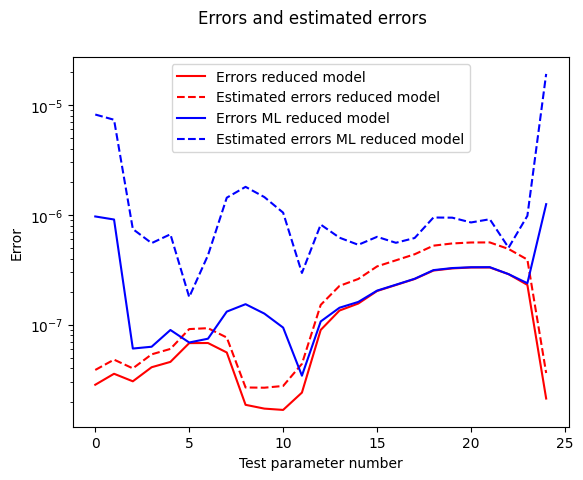

In [13]:
fig = plt.figure()
fig.suptitle("Errors and estimated errors")
ax = fig.add_subplot(111)
ax.semilogy(np.arange(len(test_parameters_analysis)), errors_rb_rom, f"-r", label="Errors reduced model")
ax.semilogy(np.arange(len(test_parameters_analysis)), estimated_errors_rb_rom, f"--r", label="Estimated errors reduced model")
ax.semilogy(np.arange(len(test_parameters_analysis)), errors_ml_rom, f"-b", label="Errors ML reduced model")
ax.semilogy(np.arange(len(test_parameters_analysis)), estimated_errors_ml_rom, f"--b", label="Estimated errors ML reduced model")
ax.set_xlabel("Test parameter number")
ax.set_ylabel("Error")
ax.legend()
plt.show()